# **Fully Connected Activity Detection**

This notebook will build a fully-connected neural network model, and a Variational Autoencoder model, to perform human activity recognition with smartphone data (https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones). This emulates the scenario of having a centralised server to perform learning where clinets send all their data.

## i. Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import gc
import torch
import numpy as np
import seaborn as sn
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

## ii. General setup

In [2]:
# Directories
basedir = os.getcwd()
datadir = os.path.join(basedir, 'data')

# Training hyperparameters
N_EPOCHS = 10
N_FEATURES = 561
BATCH_SIZE = 128
N_LABELS = 6
LEARNING_RATE = 0.001
LATENT_DIM = 100

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
# Custom functions
def bold(string):
    """
    Make string bold.

    Args:
        string (str): String to be made bold.

    Returns:
        str: Bold string.

    Raises:
        TypeError: If the input is not a string.
    """
    # Check input type
    if not isinstance(string, str):
        raise TypeError("Input must be a string!")
    
    return "\033[1m" + string + "\033[0m"

def calculate_metrics(y_true, y_pred, model, return_cm=False):
    """
    Calculate performance metrics and 
    plot confusion matrix given predictions 
    and ground truth values.

    Args:
        y_true (np.array): Array of ground truth y values.
        y_pred (np.array): Array of y value predictions.
        model (str): Name of model that generated predictions.
        return_cm (Bool): Boolean determining if confusion matric data is returned.

    Returns:
        float: Total model accuracy.
        DataFrame: DataFrame of groupwise performance metrics.
        DataFrame: Confusion matrix data (optional).
    """
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in mapping],
                         columns = [i for i in inv_mapping])
    plt.figure(figsize = (12,7))
    plt.title(f'Confusion Matrix between Activities for {model} Model')
    sns.heatmap(df_cm, annot=True)
    plt.show()

    # Calculate performance metrics
    accuracy = 100 * np.sum(y_pred == y_true) / len(y_true)
    precision = np.round(precision_score(y_true, y_pred, average=None), 2)
    recall = np.round(recall_score(y_true, y_pred, average=None), 2)
    f1 = np.round(f1_score(y_true, y_pred, average=None), 2)

    # Create perfromance table
    res_df = pd.DataFrame([precision, recall, f1],
                           columns=mapping.keys(),
                           index=['Precision', 'Recall', 'F1 Score'])

    # Print results
    print(f'Performance Metrics for {model} Model:')
    display(res_df)
    print(f'{model} Model accuracy on test set: {accuracy:.2f}%')

    # Return
    if return_cm:
        return accuracy, res_df, df_cm 
    else:
        return accuracy, res_df

## **1. Load data**

In [4]:
class ActivityDataset(Dataset):
    """
    Custom PyTorch Dataset 
    of activity data.

    Attributes:
        data_array (array): NumPy array of data.
    """

    def __init__(self, data_array):
        self.data_array = data_array

    def __len__(self):
        return len(self.data_array)
    
    def __getitem__(self, idx):
        # Convert item to tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Obtain sample, subject and label
        sample = self.data_array[idx]
        subject = sample[-2]
        sample = torch.Tensor(sample)
        label = sample[-1]
        sample = sample[:-2]
        sample = torch.Tensor(sample)

        # Obtain label and encode
        label = onehot_encoder.transform([[label]])[0]

        return sample, label, subject

In [5]:
# Load training and test data
train_file = 'train.csv'
test_file = 'test.csv'
train_data = pd.read_csv(os.path.join(datadir, train_file))
test_data = pd.read_csv(os.path.join(datadir, test_file))

# Replace activities with numeric mapping
labels = train_data['Activity'].unique().tolist()
mapping = dict(zip(labels, range(len(labels))))
inv_mapping = {v: k for k, v in mapping.items()}
train_data.replace({'Activity': mapping}, inplace=True)
test_data.replace({'Activity': mapping}, inplace=True)

# Normalise data
train_temp_columns = train_data.iloc[:, -2:]
test_temp_columns = test_data.iloc[:, -2:]
train_data_norm = train_data.iloc[:, :-2]
test_data_norm = test_data.iloc[:, :-2]
train_data_norm = (train_data_norm-train_data_norm.mean())/train_data_norm.std()
test_data_norm = (test_data_norm-test_data_norm.mean())/test_data_norm.std()
train_data_norm = pd.concat([train_data_norm, train_temp_columns], axis=1)
test_data_norm = pd.concat([test_data_norm, test_temp_columns], axis=1)

# Check feature number is correct
assert train_data.shape[1]-2 == N_FEATURES,\
       f'Training data has incorrect number of features ({train_data.shape[1]-2})! Should be {N_FEATURES}.'
assert test_data.shape[1]-2 == N_FEATURES,\
       f'Test data has incorrect number of features ({test_data.shape[1]-2})! Should be {N_FEATURES}.'

# Fit onehot encoder
onehot_encoder = OneHotEncoder(sparse=False)
train_labels = train_data_norm['Activity'].values
train_labels = train_labels.reshape(len(train_labels), 1)
onehot_encoder.fit(train_labels)

# Print some statistics
print(f'Training data points: {train_data_norm.shape[0]}')
print(f'Test data points: {test_data_norm.shape[0]}')
print(f'Feature number: {N_FEATURES}')
print(f'Label number: {N_LABELS}')

# Create Datasets
train_dataset = ActivityDataset(train_data_norm.to_numpy())
test_dataset = ActivityDataset(test_data_norm.to_numpy())

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=0)

Training data points: 7352
Test data points: 2947
Feature number: 561
Label number: 6


## **2. Fully Connected Classifier**

### 2.1 Define model

In [6]:
class FCNet(nn.Module):
    """
    Fully connected classifier.

    Attributes:
        in_features (int): Number of input features.
        out_labels (int): Number of output labels.
    """
    def __init__(self,
                 in_features,
                 out_labels):
        super(FCNet, self).__init__()

        # Assign variables
        self.in_features = in_features
        self.out_labels = out_labels

        # Define network toplogy
        modules = []
        modules.append(
            nn.Sequential(
                nn.Linear(self.in_features, self.out_labels)
                )
            )
        self.linear_model = nn.Sequential(*modules)

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters:
            x (Tensor): Tensor of input features.

        Returns:
            Tensor: Output tensor.
        """
        result = self.linear_model(x)

        return result

In [7]:
# Initiliase classifier
ActivityClassifier = FCNet(in_features=N_FEATURES, out_labels=N_LABELS).to(device)
params = sum(p.numel() for p in ActivityClassifier.parameters() if p.requires_grad)
print("Total number of parameters for the classifier: {}\n".format(params))
print("Classifier architecture:")
print(ActivityClassifier)

# Optimiser and loss
optimizer = torch.optim.Adam(ActivityClassifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Total number of parameters for the classifier: 3372

Classifier architecture:
FCNet(
  (linear_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=561, out_features=6, bias=True)
    )
  )
)


### 2.2 Train Model

In [8]:
# Initialise loss dictionary
total_loss = []

# Begin training
print('Beginning training...\n')
ActivityClassifier.train()

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Running loss containers
    running_loss = 0.0

    # Loop over batches
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for batch_idx, (data, label, subject) in enumerate(tepoch):

          # Batch tensor and add channel dimension
          batch_tensor = data.to(device)
          label = label.to(device)
          batch_tensor = batch_tensor[:, None, :]

          # Compute reconstructions
          results = ActivityClassifier(batch_tensor)
          results = results.squeeze()
          
          # Loss
          loss = criterion(results, label)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Update loss
          running_loss += loss.item()

          # Log
          if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=loss.item())

        # Average epoch loss
        total_loss.append(running_loss/batch_idx+1)

Beginning training...



  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

### 2.3. Evaluate model

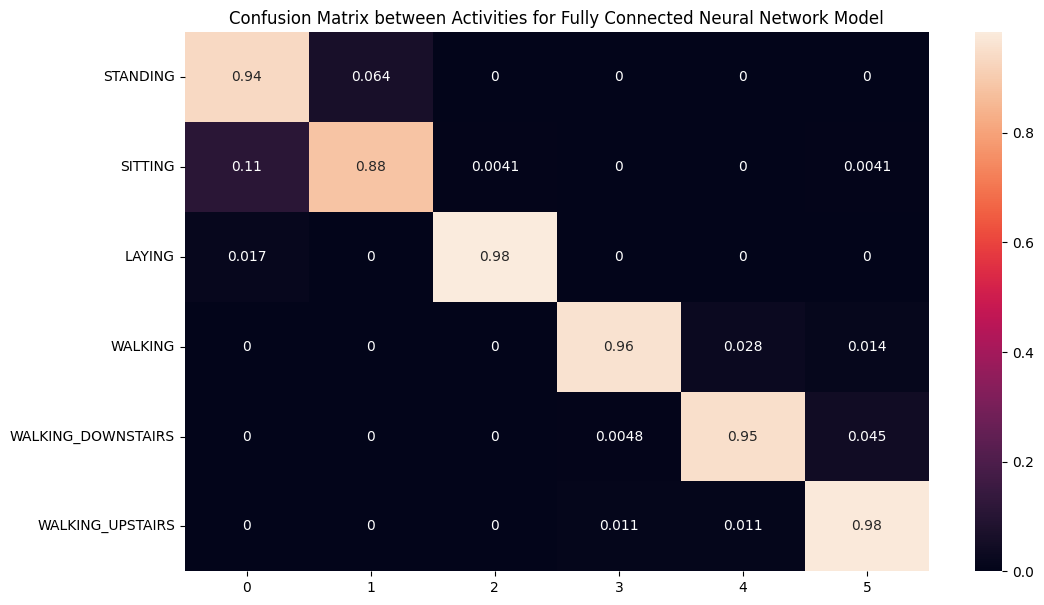

Performance Metrics for Fully Connected Neural Network Model:


,STANDING,SITTING,LAYING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
Precision,0.89,0.93,1.00,0.99,0.95,0.94
Recall,0.94,0.88,0.98,0.96,0.95,0.98
F1 Score,0.91,0.90,0.99,0.97,0.95,0.96


Fully Connected Neural Network Model accuracy on test set: 94.81%


In [12]:
# Containers for predictions
y_pred = []
y_true = []

# Put model in evaluation mode
ActivityClassifier.eval()
torch.no_grad()

# Loop over test batches
for data, labels, subject in test_dataloader:
    # Batch tensor and add channel dimension
    batch_tensor = data.to(device)
    label = label.to(device)
    batch_tensor = batch_tensor[:, None, :]

    # Obtain model predictions
    results = ActivityClassifier(batch_tensor)
    results = results.squeeze()

    # Save precitions
    output = (torch.max(torch.exp(results), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

    # Unencode labels and save
    labels = onehot_encoder.inverse_transform(labels.cpu().numpy())
    labels = np.array([x[0] for x in labels])
    y_true.extend(labels)

# Calculate performance metrics
y_pred = np.array(y_pred)
y_true = np.array(y_true)
model_name = 'Fully Connected Neural Network'
accuracy, performance_df = calculate_metrics(y_true, y_pred, model=model_name)